In [1]:
import pandas as pd
import warnings
import time
import matplotlib.pyplot as plt
from src.helper_methods import *
from src.pipe_store import *
warnings.filterwarnings('ignore')

# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# Load Dataset

In [2]:
df = pd.read_pickle('/Users/Danial/UMCUtrecht/Leuven/Processed/desa.pickle')
df = df.rename(columns={
        'death_censor':'FailureCode10Y_R',
        'surv_time_yr': 'GraftSurvival10Y_R',
        'donor_LD': 'TypeOfDonor_NOTR',
        'induction':'IL2rMoAb', 
        'donor_age':'DonorAge_NOTR',
        'rec_age':'RecipientAge_NOTR', 

    })
df['TypeOfDonor_NOTR'] = df['TypeOfDonor_NOTR'].apply(lambda x: 'Living' if x == 1 else 'Deceased')
df['CIPHour_DCD'] = df[['CIT', 'donor_DCD']].apply(lambda x: x[0] if x[1] == 1 else 0, axis=1)
df['CIPHour_DBD'] = df[['CIT', 'donor_DBD']].apply(lambda x: x[0] if x[1] == 1 else 0, axis=1)
df.sample(1)

,Tx_id,Epitope_Mismatch,DESA_Status,EpvsHLA_Donor,DESA,DESA_num,Relevant_DESA,GraftSurvival10Y_R,DonorAge_NOTR,RecipientAge_NOTR,donor_type,FailureCode10Y_R,repeat_tx,IL2rMoAb,CIT,TypeOfDonor_NOTR,donor_DCD,donor_DBD,CIPHour_DCD,CIPHour_DBD
22,3042,"{'156WA': 'C*12:03', '80K': 'C*06:02', '73AN':...",DESA,"{'116I': 'DQB1*05:01', '37YV[DQ]': 'DQB1*05:01...","{116I, 37YV[DQ], 125SQ}",3,0,3.046575,54.6,68.8,1,1,1,1,12.5,Deceased,0,1,0.0,12.5


In [3]:
df.TypeOfDonor_NOTR.value_counts()

Deceased    89
Living       5
Name: TypeOfDonor_NOTR, dtype: int64

# Finding relevant DESA using Automation

In [4]:
from src.pipe_store import df_inv_val_split
from src.helper_methods import  kaplan_meier_curves_automation, plot_kaplan_meier_curve_automation
from collections import  defaultdict
from time import time
# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def inv_val_split(df, val_size:float, donor_type='Deceased'):
    df_dead = df[df.TypeOfDonor_NOTR == donor_type]
    msk = np.random.rand(len(df_dead)) < val_size
    return (df_dead[~msk], df_dead[msk])

def cross_val_split(df, k_fold:int, donor_type='Deceased'):
    df_type = df[df.TypeOfDonor_NOTR == donor_type]
    df_type = df_type.sample(frac=1).reset_index(drop=True) # shuffle dataframe
    fold_samples = len(df_type) // k_fold + 1
    return [df_type.loc[(i-1) * fold_samples: i * fold_samples] for i in range(1, 6)]

def summerize_results(df_res, iter, add_val_res):
    freq_inv = [f'freq_iter_{i}'  for i in range(1, iter + 1)]
    avg_diff_early = [f'avg_diff_early_iter_{i}' for i in range(1, iter + 1)]
    avg_diff_mid = [f'avg_diff_mid_iter_{i}' for i in range(1, iter + 1)]
    avg_diff_late = [f'avg_diff_late_iter_{i}' for i in range(1, iter + 1)]
    p_value_inv = [f'p_value_iter_{i}' for i in range(1, iter + 1)]

    freq_val = [f'freq_val_iter_{i}' for i in range(1, iter + 1)]
    sum_diff_val = [f'sum_diff_val_iter_{i}' for i in range(1, iter + 1)]
    p_value_val = [f'p_value_val_iter_{i}' for i in range(1, iter + 1)]

    df_sum = pd.DataFrame()
    df_sum['epitope'] = df_res['epitope']
    df_sum['freq_inv'] = df_res[freq_inv].mean(axis=1)
    # df_sum['p_value_mean'] = df_res[p_value].mean(axis=1)
    df_sum['#sig_p_value_inv'] = df_res[p_value_inv].apply(lambda x: len([p_val for p_val in x if p_val < 0.05]), axis=1)
    df_sum['avg_diff_early'] = df_res[avg_diff_early].mean(axis=1)
    df_sum['avg_diff_mid'] = df_res[avg_diff_mid].mean(axis=1)
    df_sum['avg_diff_late'] = df_res[avg_diff_late].mean(axis=1)
    df_sum['repe'] = df_res[freq_inv].notna().sum(axis=1)
    if add_val_res:
        df_sum['freq_val'] = df_res[freq_val].mean(axis=1)
        df_sum['#sig_p_value_val'] = df_res[p_value_val].apply(lambda x: len([p_val for p_val in x if p_val < 0.05]), axis=1)
    return df_sum


# def find_relevant_epitope(df_inv, ep_freq:int):
#     collect_res = defaultdict(dict)
#     confounders = [
#         'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
#         'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
#         'CIPHour_DBD', 'CIPHour_DCD', 
#     ]
#     treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
#     list_set_desa = df_inv[df_inv.DESA_Status == 'DESA'].DESA.values
#     epitopes = {ep for desa_set in list_set_desa for ep in desa_set}
#     for ep in epitopes:
#         freq = df_inv.DESA.apply(lambda x: ep in x).sum()
#         if freq >= ep_freq:
#             try:
#                 df_treat_group = create_treatment_grups(df_inv, [{ep}])
#                 df_weight = find_ipw(df_treat_group, confounders, treatments, verbose=False)
#                 labels = ['Other_DESA', 'Specific_DESA']
#                 kmfs, p_value = kaplan_meier_curves_automation(df_weight, desa_spec=ep, donor_type='Deceased', labels=labels, adjust=True)
#             except Exception as e:
#                 print(f'Exception: {e} Epitope: {ep}')
#             km_rest, km_ep = kmfs[0], kmfs[1]
#             diff = km_ep.survival_function_.values - km_rest.survival_function_.values
#             collect_res[ep][f'freq'] = int(freq)
#             collect_res[ep][f'sum_diff'] = diff.sum()
#             collect_res[ep][f'p_value'] = p_value
    
#     return  pd.DataFrame(collect_res).T.reset_index().rename(columns={'index':'epitope'})


def epitope_relevance_validation(df, iter:int, ep_freq_inv:int, ep_freq_val:int, val_size:int, add_val_res:bool=False):
    collect_res = defaultdict(dict)

    confounders = [
        'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
        'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
        'CIPHour_DBD', 'CIPHour_DCD', 
    ]
    treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
    for i in range(1, iter + 1):
        now = time()
        df_inv, df_val = inv_val_split(df, val_size=val_size, donor_type='Deceased')
        print(df_inv.shape, df_val.shape)
        list_set_desa = df_inv[df_inv.DESA_Status == 'DESA'].DESA.values
        epitopes = {ep for desa_set in list_set_desa for ep in desa_set}
        for ep in epitopes:
            freq_inv = df_inv.DESA.apply(lambda x: ep in x).sum()
            freq_val = df_val.DESA.apply(lambda x: ep in x).sum()
            if (freq_inv >= ep_freq_inv) & (freq_val >= ep_freq_val):
                try:
                    df_tret_group = create_treatment_grups(df_inv, [{ep}])
                    df_weight = find_ipw(df_tret_group, confounders, treatments, verbose=False)
                    labels = ['Other_DESA', 'Specific_DESA']
                    kmfs, p_value = kaplan_meier_curves_automation(df_weight, desa_spec=ep, donor_type='Deceased', labels=labels, adjust=True)
                except Exception as e:
                    print(f'Investigation Exception: {e} Epitope: {ep}')
                    continue
                km_rest, km_ep = kmfs[0], kmfs[1]
                diff = km_ep.survival_function_.values - km_rest.survival_function_.values
                collect_res[ep][f'freq_iter_{i}'] = int(freq_inv)
                collect_res[ep][f'avg_diff_early_iter_{i}'] = diff[0:250].mean()
                collect_res[ep][f'avg_diff_mid_iter_{i}'] = diff[250:650].mean()
                collect_res[ep][f'avg_diff_late_iter_{i}'] = diff[650:].mean()
                collect_res[ep][f'p_value_iter_{i}'] = p_value
                if add_val_res:
                    try:
                        df_tret_group_val = create_treatment_grups(df_val, [{ep}])
                        df_weight_val = find_ipw(df_tret_group_val, confounders, treatments, verbose=False)
                        labels = ['Other_DESA', 'Specific_DESA']
                        kmfs_val, p_value_val = kaplan_meier_curves_automation(df_weight_val, desa_spec=ep, donor_type='Deceased', labels=labels, adjust=True)
                    except Exception as e:
                        print(f'Validation Exception: {e} Epitope: {ep}')
                    km_rest, km_ep = kmfs_val[0], kmfs_val[1]
                    diff_val = km_ep.survival_function_.values - km_rest.survival_function_.values
                    freq_val = df_val.DESA.apply(lambda x: ep in x).sum()
                    collect_res[ep][f'freq_val_iter_{i}'] = int(freq_val)
                    collect_res[ep][f'sum_diff_val_iter_{i}'] = diff_val.sum()
                    collect_res[ep][f'p_value_val_iter_{i}'] = p_value_val
        
        print(f'Iteration {i} is concluded in {time() - now} seconds')
    df_res = pd.DataFrame(collect_res).T.reset_index().rename(columns={'index':'epitope'})
    return summerize_results(df_res, iter, add_val_res), df_res

def plot_km_curve(df:pd.DataFrame, donor_type:str, ep:set, adjust:bool=False, num_curves:int=3):
    confounders = [
        'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
        'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
        'CIPHour_DBD', 'CIPHour_DCD', 
    ]

    treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
    ep = set(ep)
    labels = ['No DESA', 'Other DESA', 'Specific_DES']
    df_tret_group = create_treatment_grups(df, [ep])
    df_weight = find_ipw(df_tret_group, confounders, treatments, verbose=False)
    if num_curves == 3:
        kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=ep, donor_type=donor_type, labels=labels, adjust=adjust)
    if num_curves == 2:
        kmfs, p_value = kaplan_meier_curves_automation(df_weight, desa_spec=ep, donor_type=donor_type, labels=labels, adjust=adjust)
    plot_kaplan_meier_curve(kmfs, p_value, verbose=True, title='')



In [6]:
df.donor_type.value_counts()

1    78
2    11
0     5
Name: donor_type, dtype: int64

In [7]:
# filter on deceased donors
df_dead = df[df.TypeOfDonor_NOTR == 'Deceased']
# df_sum, df_res = epitope_cross_validation_relevance(df_dead, 5, ep_freq=3)

# df_inv, df_val = inv_val_split(df, test_size=.40, donor_type='Deceased')
# df_inv
# df_val

df_sum, df_res = epitope_relevance_validation(df_dead, iter=1, ep_freq_inv=3, ep_freq_val=0, val_size=0, add_val_res=False)

(89, 20) (0, 20)
Iteration 1 is concluded in 2.3522748947143555 seconds


In [9]:
df_res[df_res.p_value_iter_1 < 0.05].epitope.values#[df_res.sum_diff_iter_1 < -300].epitope.val

array(['37YV[DQ]', '116I', '125SQ', '76ESI'], dtype=object)

In [10]:
df_res[(df_res.avg_diff_early_iter_1 < - 0.2) & (df_res.avg_diff_late_iter_1 < - 0.2)].epitope.values

array(['76ESI'], dtype=object)

In [15]:
df_res

,epitope,freq_iter_1,avg_diff_early_iter_1,avg_diff_mid_iter_1,avg_diff_late_iter_1,p_value_iter_1


In [13]:
# df_res[df_res.epitope == '45EV']
# df_res[(df_res.p_value_iter_1 > 0.95)].epitope.values
df_res[df_res.p_value_iter_1 < 0.05].epitope.values

array(['71A', '150AAH', '193AV', '70DA', '114Q', '105S', '74A', '6C',
       '70DRA', '94I', '96HK', '44RME', '144QL', '114H', '149H', '71TD',
       '150AH', '77D'], dtype=object)

In [27]:
# df_sum['repe_relevant/rep'] = df_sum['repe_relevant']  / df_sum['repe'] 

In [124]:
relevant_desa = df_sum[(df_sum.repe_relevant >=2) & (df_sum.p_value <= 0.05)].epitope.tolist()
df_sum[(df_sum.repe_relevant >=2) & (df_sum.p_value <= 0.05)]
# df_sum[df_sum.p_value <= 0.05]
# # print(df_sum[df_sum.p_value <= 0.05].epitope.tolist())

,epitope,freq,p_value,sum_diff,repe,repe_relevant
139,71TD,5.40,0.006153,-553.369600,5,5
152,144QL,3.75,0.039876,-512.022145,4,3
203,114H,3.00,0.000032,-421.641358,2,2
215,77D,3.00,0.038458,-164.652426,2,2
220,74A,4.00,0.015570,-275.348628,2,2
221,114Q,3.00,0.000018,-715.886175,2,2


In [28]:
# df_res['144QL']

In [125]:
df_sum[df_sum.epitope == '45EV']

,epitope,freq,p_value,sum_diff,repe,repe_relevant
93,45EV,12.0,0.214668,-150.03378,5,1


Top curve: 57.48, Middle curve:  66.13, Lower curve: 17.14
10-Year Gap is:  48.99
1-Year Gap is:  14.29


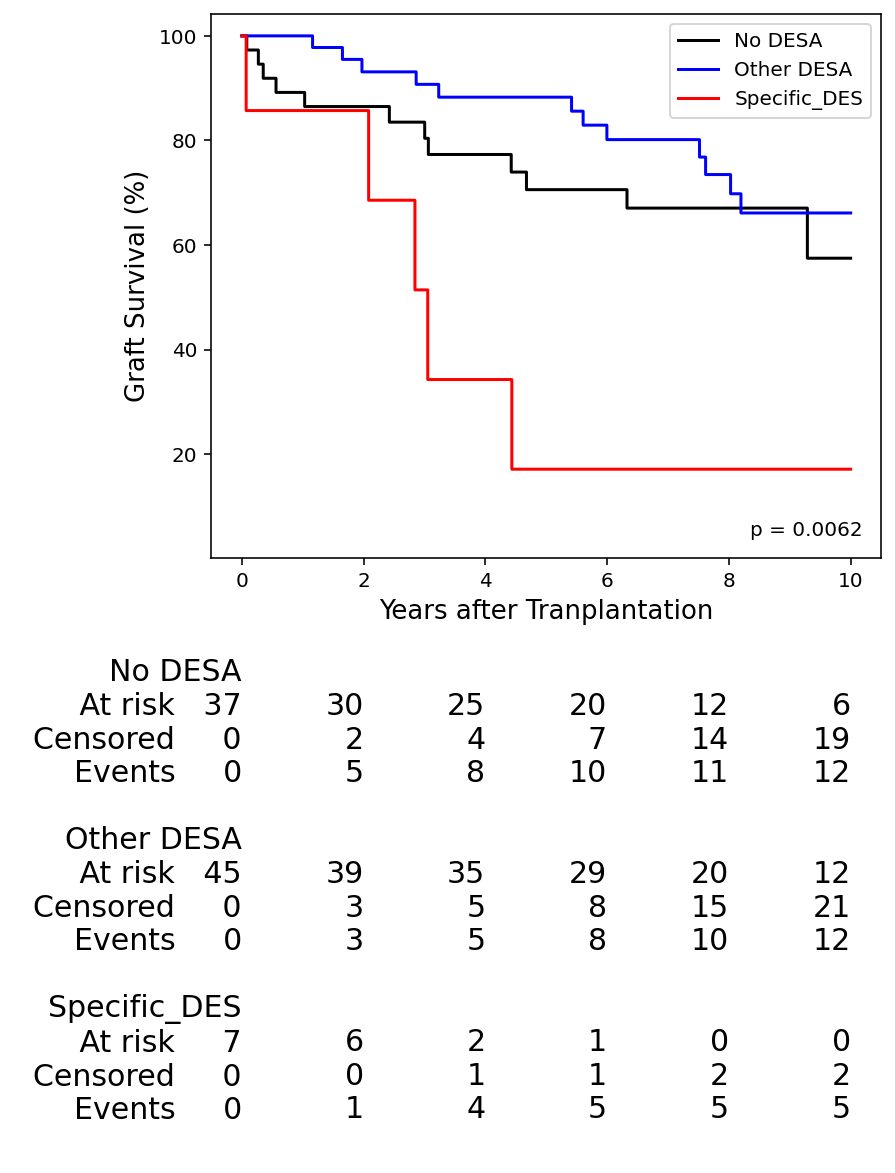

In [9]:
df_dead = df[df.TypeOfDonor_NOTR == 'Deceased']
relevant_desa = ['125SQ', '116I', '37YV[DQ]', '76ESI']
plot_km_curve(df_dead, donor_type='Deceased', ep=relevant_desa, adjust=False)

In [24]:
# relevant_desa = ['74A', '94I', '71TD', '150AH', '193AV', '150AAH', '76ED', '144QL', '114H', '66IY', '114Q', '105S', ]
                

In [90]:

class_I = { '44RMA', '45KE', '56R', '62EE', '62GRN', '62QE', '65QIA', '66NH', '71TD', '73ID', '74Y', '76ED', '76VDT', '80TLR', '94I', '97V', 
           '105S', '144QL', '150AAH', '150AH', '158T', '193AV', '207S', '245AS' }
class_II_dr = {'4Q', '6C', '30D', '30G[DR]', '31FY', '31FH', '32H', '37S', '67F', '70DA', '70DRA', '71A', '74A', '74L', '96EV', '96HK', '108T', '140TV', '142M', '149H'}
class_II_dq = {'45GV','45EV', '46VY'}

good_epitopes = {
    '30C', '37F', '37YV[DQ]', '55PPA', '62LQ', '71ATD', '71QS', '73AN', '73TVS', '80I', '97S', 
    '130Q', '147L', '152A', '152RA', '152RR', '163RW', '173K', '177DT', '180E', '193PL', '267QE',
    '44RT', '245V',
}


old_rel_desa = class_I | class_II_dr | class_II_dq
# confounders = [
#     'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
#     'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
#     'CIPHour_DBD', 'CIPHour_DCD', 
# ]

# treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
# # treatments = [ 'Other_DESA', 'Specific_DESA']
# # ep = {'77T[DQ]'}
# ep = set(relevant_desa)
# labels = ['No DESA', 'Other DESA', 'Specific_DESA']

# df_tret_group = create_treatment_grups(df, [ep])
# df_weight = find_ipw(df_tret_group, confounders, treatments, verbose=False)

# kmfs, p_value = kaplan_meier_curves_automation(df_weight, desa_spec=ep, donor_type='Deceased', labels=labels, adjust=True)
# plot_kaplan_meier_curve_automation(kmfs, p_value, verbose=True, title='Deceased Donor (N=3235)')

In [91]:
old_rel_desa & set(relevant_desa)

{'149H',
 '150AAH',
 '245AS',
 '45EV',
 '46VY',
 '62QE',
 '66NH',
 '70DA',
 '70DRA',
 '71A',
 '74A',
 '94I',
 '96HK'}

# Validation

Top curve: 51.51, Lower curve: 46.67
10-Year Gap is:  4.85
1-Year Gap is:  8.27


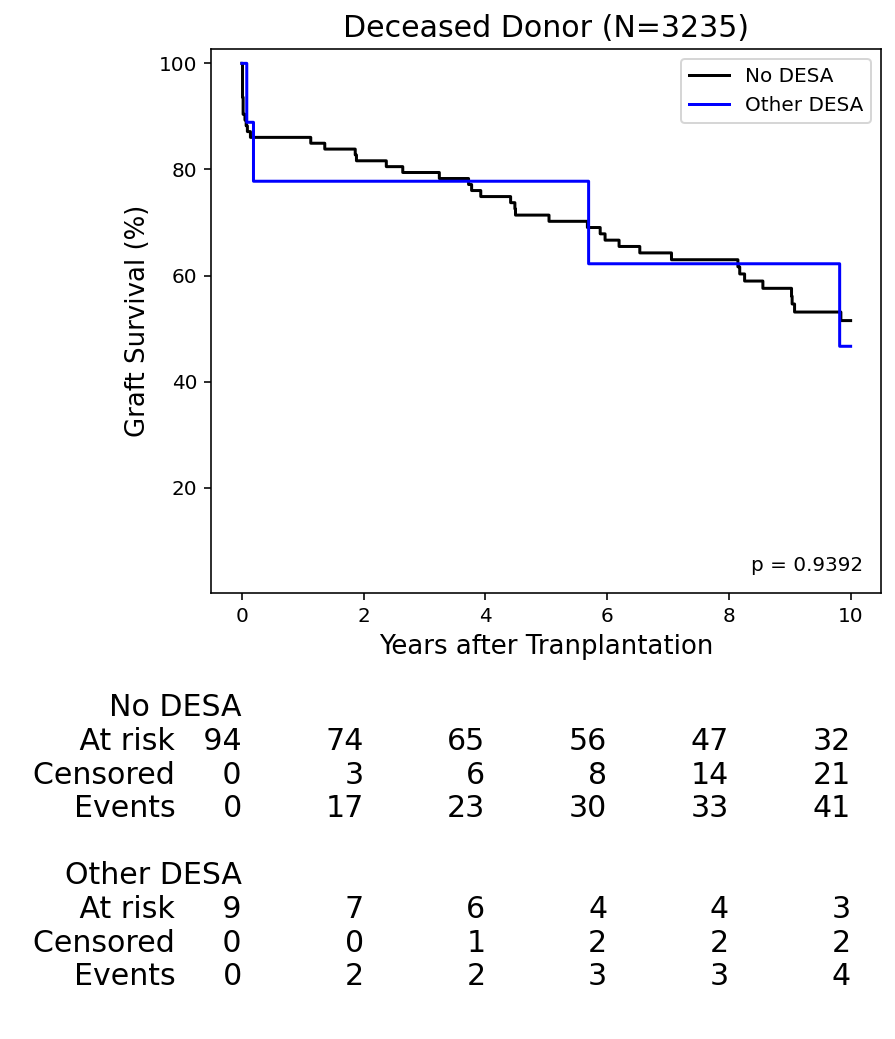

In [108]:

plot_km_curve(df_val, donor_type='Deceased', ep=relevant_desa, adjust=False)

In [123]:
df_living = df[df.TypeOfDonor_NOTR == 'Living']
plot_km_curve(df_living, donor_type='Living', ep=relevant_desa, adjust=False)

ValueError: zero-size array to reduction operation maximum which has no identity